In [151]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import roc_auc_score
from torchvision import transforms

import videotransforms
from evaluator import Evaluator
from mit_data import MITDataset as Dataset
from pytorch_i3d import InceptionI3d

In [70]:
test_transforms = transforms.Compose([videotransforms.CenterCrop(224)])

In [71]:
dataset = Dataset(
    mode="train",
    transforms=test_transforms,
    index_file="data/MIT_data/binary_label_man.csv",
    split_file="binary_split.csv")
val_dataset = Dataset(
    mode="val",
    transforms=test_transforms,
    index_file="data/MIT_data/binary_label_man.csv",
    split_file="binary_split.csv")

num_classes = len(dataset.mlb.classes_)

i3d = InceptionI3d(400, in_channels=3, spatial_squeeze=True)
i3d.replace_logits(num_classes)
checkpoint = torch.load("learning_history/binary.pt000400.pt", map_location="cpu")
i3d.load_state_dict(checkpoint)
i3d.eval()

InceptionI3d(
  (avg_pool): AvgPool3d(kernel_size=[2, 7, 7], stride=(1, 1, 1), padding=0)
  (dropout): Dropout(p=0.5)
  (logits): Unit3D(
    (conv3d): Conv3d(1024, 2, kernel_size=[1, 1, 1], stride=(1, 1, 1))
  )
  (Conv3d_1a_7x7): Unit3D(
    (conv3d): Conv3d(3, 64, kernel_size=[7, 7, 7], stride=(2, 2, 2), bias=False)
    (bn): BatchNorm3d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  )
  (MaxPool3d_2a_3x3): MaxPool3dSamePadding(kernel_size=[1, 3, 3], stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (Conv3d_2b_1x1): Unit3D(
    (conv3d): Conv3d(64, 64, kernel_size=[1, 1, 1], stride=(1, 1, 1), bias=False)
    (bn): BatchNorm3d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  )
  (Conv3d_2c_3x3): Unit3D(
    (conv3d): Conv3d(64, 192, kernel_size=[3, 3, 3], stride=(1, 1, 1), bias=False)
    (bn): BatchNorm3d(192, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  )
  (MaxPool3d_3a_3x3): MaxPool3dSamePadding(kernel_

In [73]:
class ClassifyAnalyser():
    def __init__(self,label_binarizer):
        self.mlb = label_binarizer
        
    def show_video(self,tensor, frame=10):
        """
        tensor has shape (C x T x W x H)
        """
        video_array = tensor.numpy()
        video_array = np.transpose(video_array, axes=[1, 2, 3, 0])
        image = video_array[frame].astype('uint8')
        fig, ax = plt.subplots()
        ax.imshow(image)
        ax.set_axis_off()
        return fig, ax
    
    def label_prob(self, logit):
        """
        logit has shape (N, T)
        (N is number of class)
        """
        predict = torch.max(logit, dim=1)[0]
        prob = torch.sigmoid(predict)
        prob_array = prob.data.numpy()
        prob_dict = { self.mlb.classes_[i]:prob_array[i] for i in range(2)}
        return prob_dict

In [74]:
analyzer = ClassifyAnalyser(dataset.mlb)

In [87]:
sample = val_dataset[120]
video = sample["video"].unsqueeze(0)
label = sample["label"]

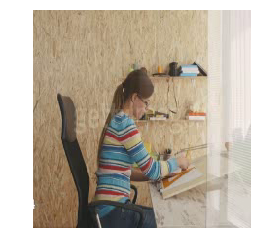

In [88]:
logit=i3d(video)
predicted_label = analyzer.label_prob(logit[0])
fig, ax = analyzer.show_video(video[0])

In [89]:
predicted_label

{'man': 0.39284644, 'nan': 0.43163994}

In [90]:
label

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [92]:
dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=2,
    shuffle=False
)

In [93]:
for sample in dataloader:
    video = sample["video"]
    label = sample["label"]
    print(video.size())
    print(label.size())

torch.Size([2, 3, 90, 224, 224])
torch.Size([2, 2, 90])
torch.Size([2, 3, 90, 224, 224])
torch.Size([2, 2, 90])
torch.Size([2, 3, 90, 224, 224])
torch.Size([2, 2, 90])
torch.Size([2, 3, 90, 224, 224])
torch.Size([2, 2, 90])
torch.Size([2, 3, 90, 224, 224])
torch.Size([2, 2, 90])
torch.Size([2, 3, 90, 224, 224])
torch.Size([2, 2, 90])
torch.Size([2, 3, 90, 224, 224])
torch.Size([2, 2, 90])
torch.Size([2, 3, 90, 224, 224])
torch.Size([2, 2, 90])
torch.Size([2, 3, 90, 224, 224])
torch.Size([2, 2, 90])
torch.Size([2, 3, 90, 224, 224])
torch.Size([2, 2, 90])
torch.Size([2, 3, 90, 224, 224])
torch.Size([2, 2, 90])
torch.Size([2, 3, 90, 224, 224])
torch.Size([2, 2, 90])
torch.Size([2, 3, 90, 224, 224])
torch.Size([2, 2, 90])
torch.Size([2, 3, 90, 224, 224])
torch.Size([2, 2, 90])
torch.Size([2, 3, 90, 224, 224])
torch.Size([2, 2, 90])
torch.Size([2, 3, 90, 224, 224])
torch.Size([2, 2, 90])
torch.Size([2, 3, 90, 224, 224])
torch.Size([2, 2, 90])
torch.Size([2, 3, 90, 224, 224])
torch.Size([2, 

In [94]:
sample = next(iter(dataloader))

In [96]:
video = sample["video"]
label = sample["label"]
logits = i3d(video)

In [98]:
logits.size()

torch.Size([2, 2, 11])

In [99]:
labels = list(label)

In [100]:
labels

[tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.

In [101]:
empty = []
empty + labels

[tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.

In [105]:
with open("binary_result.pkl", "rb") as f:
    result = pickle.load(f)

In [107]:
result[0]["label"]

array([ 1.,  0.], dtype=float32)

In [108]:
num_classes = 2

for class in categories

    true_label_vector = something
    
    label_prob_vector = blah
    
    predicted_prob_vector = blah
    
    precision_vector = aaaa
    
    accuracy = sum(precision_vector)/len(precision_vector)
    



In [126]:
label_list = []
prob_list = []
for sample in result:
    label_list.append(sample["label"])
    prob_list.append(sample["prob"])
label_matrix = np.array(label_list).astype("bool")
prob_matrix = np.array(prob_list)

In [133]:
thresh = 0.5
predicted_matrix = prob_matrix > thresh
classify_accuracy_matrix = predicted_matrix == label_matrix

In [139]:
classify_accuracy.mean(axis=0)

array([ 0.71974522,  0.72611465])

In [130]:
label_matrix == predicted_matrix

array([[ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [False, False],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [False, False],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [False,  True],
       [False, False],
       [ True,  True],
       [ True,  True],
       [False, False],
       [ True,  True],
       [False, False],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [False, False],
       [ True,  True],
       [False,  True],
       [ True,  True],
       [ True,  True],
       [False, False],
       [ True, False],
       [ True,  True],
       [False,  True],
       [ True, False],
       [ Tr

In [147]:
auc_list = []
for c in range(label_matrix.shape[1]):
    category_label = label_matrix[:, c]
    category_score = prob_matrix[:, c]
    print(category_label)
    print(category_score)
    auc = roc_auc_score(category_label, category_score)
    auc_list.append(auc)

[ True False False False  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False]
[ 0.99999785  0.23882444  0.32100528  0.206

In [149]:
auc_list

[0.82575757575757569, 0.80648880105401843]

In [153]:
evaluator = Evaluator()
evaluator.load_result("binary_result.pkl")

In [155]:
evaluator.stats_setup()
evaluator.accuracy()

array([ 0.71974522,  0.72611465])

In [156]:
evaluator.auc()

[0.82575757575757569, 0.80648880105401843]